# Pymaceuticals Inc.
---

### Analysis
##### Analysis can go here or at the bottom of the file.  I usually put it at the end.
1.  
2.
3. 

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
study_df = pd.merge(study_results, mouse_metadata, on="Mouse ID",how="left")

# Display the data table for preview
study_df.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.0,0,Capomulin,Female,9,22
1,f932,0,45.0,0,Ketapril,Male,15,29
2,g107,0,45.0,0,Ketapril,Female,2,29
3,a457,0,45.0,0,Ketapril,Female,11,30
4,c819,0,45.0,0,Ketapril,Male,21,25


In [2]:
# Checking the number of mice.
len(study_df['Mouse ID'].unique())

249

In [3]:
# Look for duplicates between Mouse ID and Timepoint pairs
dupes = study_df[study_df.duplicated(['Mouse ID', 'Timepoint'], keep=False)]
dupes

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
107,g989,0,45.000000,0,Propriva,Female,21,26
137,g989,0,45.000000,0,Propriva,Female,21,26
329,g989,5,48.786801,0,Propriva,Female,21,26
360,g989,5,47.570392,0,Propriva,Female,21,26
620,g989,10,51.745156,0,Propriva,Female,21,26
681,g989,10,49.880528,0,Propriva,Female,21,26
815,g989,15,51.325852,1,Propriva,Female,21,26
869,g989,15,53.442020,0,Propriva,Female,21,26
950,g989,20,55.326122,1,Propriva,Female,21,26
1111,g989,20,54.657650,1,Propriva,Female,21,26


In [4]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
dupe_list = dupes['Mouse ID'].unique()
dupe_list

array(['g989'], dtype=object)

In [5]:
# Optional: Get all the data for the duplicate mouse ID.
dupe_mouse = study_df[study_df['Mouse ID'].isin(dupe_list)]
dupe_mouse

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
107,g989,0,45.000000,0,Propriva,Female,21,26
137,g989,0,45.000000,0,Propriva,Female,21,26
329,g989,5,48.786801,0,Propriva,Female,21,26
360,g989,5,47.570392,0,Propriva,Female,21,26
620,g989,10,51.745156,0,Propriva,Female,21,26
681,g989,10,49.880528,0,Propriva,Female,21,26
815,g989,15,51.325852,1,Propriva,Female,21,26
869,g989,15,53.442020,0,Propriva,Female,21,26
950,g989,20,55.326122,1,Propriva,Female,21,26
1111,g989,20,54.657650,1,Propriva,Female,21,26


In [6]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID (aka remove all records for that mouse)
# There are multiple ways of doing this and it is good to search online to see the suggestions.
study_clean_df = pd.DataFrame(study_df[~study_df['Mouse ID'].isin(dupe_list)])
study_clean_df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,f932,0,45.000000,0,Ketapril,Male,15,29
2,g107,0,45.000000,0,Ketapril,Female,2,29
3,a457,0,45.000000,0,Ketapril,Female,11,30
4,c819,0,45.000000,0,Ketapril,Male,21,25
...,...,...,...,...,...,...,...,...
1888,r944,45,41.581521,2,Capomulin,Male,12,25
1889,u364,45,31.023923,3,Capomulin,Male,18,17
1890,p438,45,61.433892,1,Ceftamin,Female,11,26
1891,x773,45,58.634971,4,Placebo,Female,21,30


In [7]:
# Checking the number of mice in the clean DataFrame.
len(study_clean_df['Mouse ID'].unique())

248

## Summary Statistics

In [8]:
# Method 1:  Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# by using groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary dataframe.

by_regimen = study_clean_df.groupby(['Drug Regimen'])
mean = by_regimen['Tumor Volume (mm3)'].mean()
median = by_regimen['Tumor Volume (mm3)'].median()
var = by_regimen['Tumor Volume (mm3)'].var()
std = by_regimen['Tumor Volume (mm3)'].std()
sem = by_regimen['Tumor Volume (mm3)'].sem()

In [9]:
summary_stats = pd.DataFrame({'Mean Tumor Volume' : mean,
                             'Median Tumor Volume' : median,
                             'Tumor Volume Variance' : var,
                             'Tumor Volume Std. Dev.' : std,
                             'Tumor Volume Std. Err.' : sem})
summary_stats

,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Variance,Tumor Volume Std. Dev.,Tumor Volume Std. Err.
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [37]:
# Method 2:  Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# by using the aggregation method, produce the same summary statistics in a single line
summary_stats2 = study_clean_df.agg(['mean','median'],columns=['Tumor Volume (mm3)'])
summary_stats2


,Timepoint,Tumor Volume (mm3),Metastatic Sites,Age_months,Weight (g)
mean,19.606383,50.435293,1.025,12.757979,25.660106
median,20.000000,48.933454,1.000,13.000000,27.000000


## Bar and Pie Charts

Text(0, 0.5, 'Number of Mice Tested')

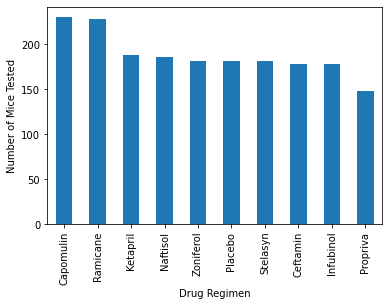

In [47]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using Pandas.
bar_regimen = by_regimen['Timepoint'].count()
bar_regimen = bar_regimen.sort_values(ascending=False)
bar_regimen.plot(kind='bar')
plt.ylabel('Number of Mice Tested')

Text(0, 0.5, 'Number of Mice Tested')

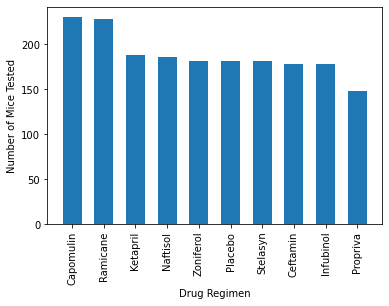

In [68]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using pyplot.
x_axis = np.arange(1,len(bar_regimen) + 1)
plt.bar(x_axis,bar_regimen,width=.6)
plt.xticks(x_axis,bar_regimen.index,rotation='vertical')
plt.xlabel('Drug Regimen')
plt.ylabel('Number of Mice Tested')

<AxesSubplot:ylabel='Sex'>

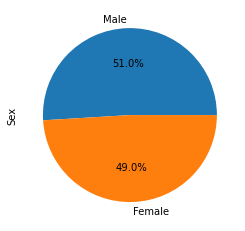

In [75]:
# Method1:  Generate a pie plot showing the distribution of female versus male mice using Pandas
# To clarify:  This answers the question:  of all the measurements taken, what percent where on male and female mice.
# This is different than:  of all the mice, what percent were male and female?

by_sex = study_clean_df.groupby(['Sex'])
by_sex = by_sex['Sex'].count()
by_sex = by_sex.sort_values(ascending=False)
by_sex.plot(kind='pie',autopct = lambda p:f'{p:.1f}%')

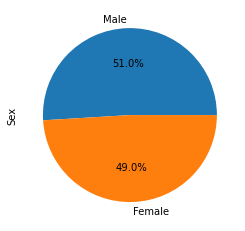

In [11]:
# Method1:  Generate a pie plot showing the distribution of female versus male mice using Pandas
# To clarify:  This answers the question:  of all the measurements taken, what percent where on male and female mice.
# This is different than:  of all the mice, what percent were male and female?





Text(0, 0.5, 'Sex')

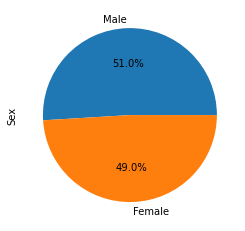

In [82]:
# Method 2:  Generate a pie plot showing the distribution of female versus male mice using matplotlib (aka pyplot, plt)
# Same clarification as above.
labels = by_sex.index
plt.pie(by_sex,labels=labels,autopct = lambda p:f'{p:.1f}%')
plt.ylabel('Sex')

## Quartiles, Outliers and Boxplots

In [15]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin
# Start by getting the last (greatest) timepoint for each mouse

final_tp = study_clean_df.groupby(['Drug Regimen','Mouse ID'])
final_tp_df = pd.DataFrame(final_tp['Timepoint'].max())
final_tp_df

Timepoint
Drug Regimen Mouse ID           
Capomulin    b128             45
             b742             45
             f966             20
             g288             45
             g316             45
...                          ...
Zoniferol    q633             45
             s337             45
             w140              5
             w575             45
             x613             15

[248 rows x 1 columns]

In [17]:
# Merge this group df with the original dataframe to get the tumor volume at the last timepoint
final_tp_df = pd.merge(final_tp_df,study_clean_df,how='left',
                       on=['Drug Regimen','Mouse ID','Timepoint'])
final_tp_df

,Drug Regimen,Mouse ID,Timepoint,Tumor Volume (mm3)_x,Metastatic Sites_x,Sex_x,Age_months_x,Weight (g)_x,Tumor Volume (mm3)_y,Metastatic Sites_y,Sex_y,Age_months_y,Weight (g)_y
0,Capomulin,b128,45,38.982878,2,Female,9,22,38.982878,2,Female,9,22
1,Capomulin,b742,45,38.939633,0,Male,7,21,38.939633,0,Male,7,21
2,Capomulin,f966,20,30.485985,0,Male,16,17,30.485985,0,Male,16,17
3,Capomulin,g288,45,37.074024,1,Male,3,19,37.074024,1,Male,3,19
4,Capomulin,g316,45,40.159220,2,Female,22,22,40.159220,2,Female,22,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,Zoniferol,q633,45,70.827796,2,Male,12,25,70.827796,2,Male,12,25
244,Zoniferol,s337,45,62.109651,4,Male,14,27,62.109651,4,Male,14,27
245,Zoniferol,w140,5,47.717952,0,Female,19,30,47.717952,0,Female,19,30
246,Zoniferol,w575,45,68.401286,3,Female,16,28,68.401286,3,Female,16,28


In [14]:
# Put treatments into a list for for loop (and later for plot labels)
# More information should be provided about this part since it is confusing and difficult.
# Part of this is similar to Day3 but **the suggestions make more sense** if you know you are doing
# this so so you have 4 lists contained inside a list bc this is used to generate the boxplot in the next cell.


# Create empty list to fill with tumor vol data (for plotting)


# Calculate the IQR and quantitatively determine if there are any potential outliers. 

    
    # Locate the rows which contain mice on each drug and get the tumor volumes
    
    
    # add subset 
    
    
    # Determine outliers using upper and lower bounds

    
    
    
    
    
# Print results of each drugs outliers - results printed don't need to look pretty.  See below.    
# Note:  in the output below:  '31   36.32346' is series index 31 and value 36.32346.  There is only one outlier.



Capomulin's potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)
Ramicane's potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)
Infubinol's potential outliers: 31    36.321346
Name: Tumor Volume (mm3), dtype: float64
Ceftamin's potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)


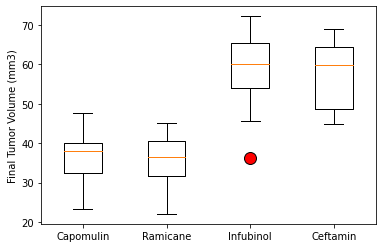

In [15]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest





## Line and Scatter Plots

In [46]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin
capomulin = study_clean_df.loc[(study_clean_df['Drug Regimen'] == 'Capomulin'),:]
capomulin['Mouse ID'].value_counts()

b128    10
v923    10
m957    10
i557    10
t565    10
l897    10
g288    10
g316    10
y793    10
r944    10
i738    10
w914    10
j119    10
u364    10
s710    10
l509    10
x401    10
b742    10
s185    10
r554    10
m601    10
j246     8
f966     5
r157     4
w150     3
Name: Mouse ID, dtype: int64

In [43]:
capomulin_b128 = capomulin.loc[capomulin['Mouse ID'] == 'b128',:]
capomulin_b128 = capomulin_b128.sort_values(by='Timepoint')
capomulin_b128

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
472,b128,5,45.651331,0,Capomulin,Female,9,22
679,b128,10,43.270852,0,Capomulin,Female,9,22
719,b128,15,43.784893,0,Capomulin,Female,9,22
933,b128,20,42.731552,0,Capomulin,Female,9,22
1268,b128,25,43.262145,1,Capomulin,Female,9,22
1400,b128,30,40.605335,1,Capomulin,Female,9,22
1547,b128,35,37.967644,1,Capomulin,Female,9,22
1629,b128,40,38.379726,2,Capomulin,Female,9,22
1764,b128,45,38.982878,2,Capomulin,Female,9,22


Text(0.5, 0, 'Timepoint (days)')

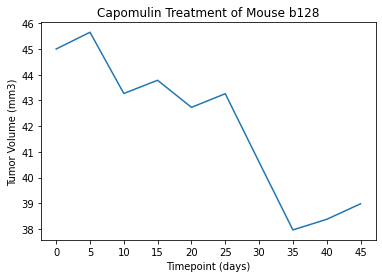

In [42]:
x_axis_cap = np.arange(0,len(capomulin_b128['Timepoint']))
labels_cap = capomulin_b128['Timepoint']
y_axis_cap = capomulin_b128['Tumor Volume (mm3)']
plt.plot(x_axis_cap,y_axis_cap)
plt.xticks(x_axis_cap, labels=labels_cap)
plt.title('Capomulin Treatment of Mouse b128')
plt.ylabel('Tumor Volume (mm3)')
plt.xlabel('Timepoint (days)')

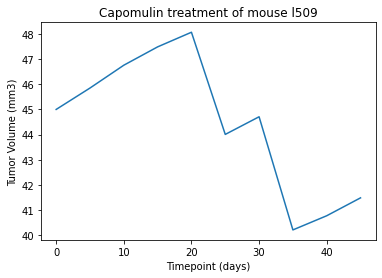

In [16]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin









In [48]:
# Generate a scatter plot of average tumor volume vs. average mouse weight of each mouse treated with the Capomulin regimen
# The chart below shows a dot for each mouse treated with Capomulin using average weight and average tumor Volume.
#  I would make the X-label say something like "Average Weight (g)"
cap_by_mouse = capomulin.groupby('Mouse ID')
avg_weight = cap_by_mouse['Weight (g)'].mean()
avg_tumor_size = cap_by_mouse['Tumor Volume (mm3)'].mean()

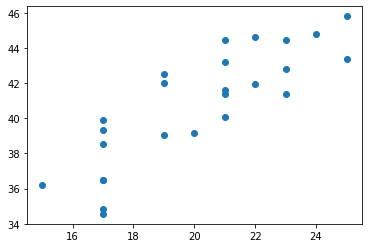

In [49]:
plt.scatter(avg_weight,avg_tumor_size)

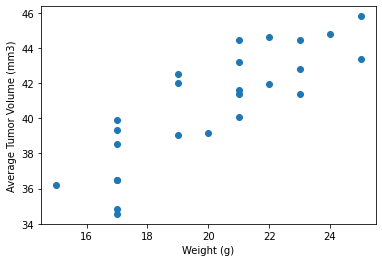

In [17]:
# Generate a scatter plot of average tumor volume vs. average mouse weight of each mouse treated with the Capomulin regimen
# The chart below shows a dot for each mouse treated with Capomulin using average weight and average tumor Volume.
#  I would make the X-label say something like "Average Weight (g)"







## Correlation and Regression

In [54]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
correlation = st.pearsonr(avg_weight,avg_tumor_size)
print("The correlation between average mouse weight and average tumor volume" +
      f" for mice under the Capomulin regimen is {round(correlation[0],2)}. ")


The correlation between average mouse weight and average tumor volume for mice under the Capomulin regimen is 0.84. 


Text(21, 36, 'y = 0.95x + 21.55 ')

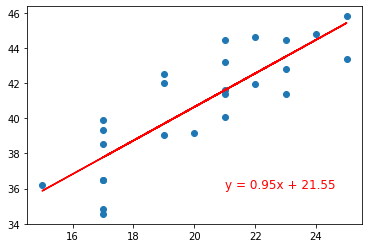

In [73]:
(slope,intercept,rvalue,pvalue,stderr) = st.linregress(avg_weight, avg_tumor_size)
best_fit = avg_weight * slope + intercept
line_annotate = f"y = {round(slope,2)}x + {round(intercept,2)} "
plt.scatter(avg_weight,avg_tumor_size)
plt.plot(avg_weight,best_fit,color='red')
plt.annotate(line_annotate,(21,36), color='red',fontsize=12)

In [66]:
line_annotate

'y = 0.95x + 21.55 '

The correlation between mouse weight and the average tumor volume is 0.84


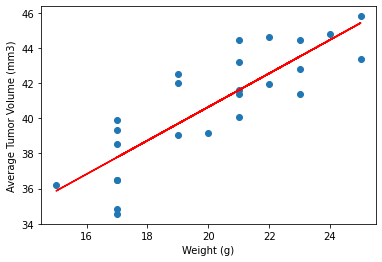

In [18]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen










